In [25]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import plotly.express as px
from scipy import stats
import optuna
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn import metrics

## Часть 1. Загрузка подготовленного датасета. ##

In [5]:
df = pd.read_pickle('data/df_for_model.pickle')
df = df.drop(['log_target'], axis=1)
df.head(3)

,status,propertyType,street,baths,fireplace,sqft,beds,stories,target,private_pool,...,heating,cooling,lot_size,school_rate_mean,school_distance_mean,has_parking,garage,parking_spaces,states_shoted,cities_shorted
1,for sale,single,avenue,3,0,1947.0,3,2,310000.0,0,...,no_heat,0,5828.0,2.666667,1.326667,0,0,0,WA,others
2,for sale,single,road,2,1,3000.0,3,1,2895000.0,1,...,forced_air,1,8626.0,6.666667,1.960000,1,1,0,CA,los angeles
3,for sale,single,avenue,8,1,6457.0,5,3,2395000.0,0,...,forced_air,1,8220.0,9.250000,0.752500,1,1,0,TX,dallas


In [6]:
''' Подготовим список категориальных признаков и числовых признаков'''
str_col = ['status','propertyType','street','heating','states_shoted','cities_shorted']
num_col = ['baths',
 'fireplace',
 'sqft',
 'beds',
 'stories',
 'private_pool',
 'year_built',
 'cooling',
 'lot_size',
 'school_rate_mean',
 'school_distance_mean',
 'has_parking',
 'garage',
 'parking_spaces']


## Часть 2. Выбор модели регрессии. ##

In [7]:
''' Создание копии исходного датасета, кодирование категориальных признаков'''
dft = df.copy()
print(f'Размер датасета до кодирования категориальных признаков {dft.shape}')
dft = pd.concat([dft, pd.get_dummies(dft[str_col])], axis=1)
dft = dft.drop(['status','propertyType','street','heating','states_shoted','cities_shorted',], axis=1)
print(f'Размер датасета {dft.shape}')

Размер датасета до кодирования категориальных признаков (348298, 21)
Размер датасета (348298, 194)


In [8]:
'''Разделение данных на тестовую и тренировочную выборки'''
X = dft.drop(['target'], axis=1)
y = dft['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
'''Предподготовка данных'''
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

In [10]:
table_dict = dict()
table_columns = ['Тренировчный', 'Тествовый']

base_line linear regression

In [17]:
# за отправную точку возьмем линейную регрессию
lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
y_train_pred = lin_regr.predict(X_train)
y_test_pred = lin_regr.predict(X_test)

table_dict['Linear regression'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 368927.95467205165
Test RMSE: 371023.02902920434


модель random forest regressor

In [18]:
'''Постраемся улучшить предсказания используя RandomForest'''
rf_best_params = {'criterion': 'squared_error', 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}

randfor = RandomForestRegressor(random_state=42, **rf_best_params)
randfor.fit(X_train_scaled, y_train)
y_train_pred = randfor.predict(X_train_scaled)
y_test_pred  = randfor.predict(X_test_scaled)

table_dict['Random Forest'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 357009.65183225577
Test RMSE: 363979.78188651847


модель xgbregressor

In [20]:
''' И наконец воспользуемся XGBRegressor сдефолтными настройками '''
xgb = XGBRegressor(seed=42)
xgb.fit(X_train_scaled, y_train)
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred  = xgb.predict(X_test_scaled)

table_dict['XGBoost'] = [
    mean_squared_error(y_train, y_train_pred, squared=False),
    mean_squared_error(y_test, y_test_pred, squared=False)
]

print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 262844.91247013584
Test RMSE: 282854.47852583375


In [21]:
'''Наилучший результат показала модель регрессии XGBoost'''
final_table = pd.DataFrame.from_dict(data=table_dict, orient='index', columns=table_columns)
final_table.round()

,Train,Test
Linear regression (r12n),368928.0,371023.0
Random Forest,357010.0,363980.0
XGBoost,262845.0,282854.0


## Часть 3. Модель XGBoost. ##

In [22]:
''' Постараемся подобрать оптимальные гиперпараметры модели XGBoost показавшей
наилучшие результаты с использованием библиотеки Optuna'''
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0)
        
    }
    model = XGBRegressor(seed = 42, **param)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred, squared=False)

In [11]:
# Create the study
optuna.visualization.is_available()
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=5)

[I 2023-12-06 21:55:52,285] A new study created in memory with name: regression
[I 2023-12-06 21:56:34,333] Trial 0 finished with value: 331225.6830055093 and parameters: {'max_depth': 9, 'learning_rate': 0.01574221120942059, 'n_estimators': 441, 'min_child_weight': 10, 'gamma': 0.6707209451069464, 'subsample': 0.8881213139866544, 'colsample_bytree': 0.12413226262191117, 'reg_alpha': 0.16822080582595858, 'reg_lambda': 0.5458268558886962}. Best is trial 0 with value: 331225.6830055093.
[I 2023-12-06 22:01:37,519] Trial 1 finished with value: 258969.91937812365 and parameters: {'max_depth': 10, 'learning_rate': 0.01650161066734016, 'n_estimators': 927, 'min_child_weight': 9, 'gamma': 0.4821188404382099, 'subsample': 0.9135612177628304, 'colsample_bytree': 0.808163137991467, 'reg_alpha': 0.4006455008122476, 'reg_lambda': 0.25961109573442}. Best is trial 1 with value: 258969.91937812365.
[I 2023-12-06 22:03:41,940] Trial 2 finished with value: 312603.81443005183 and parameters: {'max_depth

In [12]:
study.optimize(objective, n_trials=35)

[I 2023-12-06 22:10:35,985] Trial 5 finished with value: 399628.84937239095 and parameters: {'max_depth': 5, 'learning_rate': 0.791429223876852, 'n_estimators': 764, 'min_child_weight': 6, 'gamma': 0.8834571201068376, 'subsample': 0.27958846201567117, 'colsample_bytree': 0.9053686538258173, 'reg_alpha': 0.6398487207117788, 'reg_lambda': 0.5447957990517379}. Best is trial 1 with value: 258969.91937812365.
[I 2023-12-06 22:11:32,567] Trial 6 finished with value: 277062.0359064567 and parameters: {'max_depth': 7, 'learning_rate': 0.4540710238450949, 'n_estimators': 495, 'min_child_weight': 6, 'gamma': 0.5499696444738131, 'subsample': 0.511485010167603, 'colsample_bytree': 0.22183262404845858, 'reg_alpha': 0.7265131614425244, 'reg_lambda': 0.16385868774324178}. Best is trial 1 with value: 258969.91937812365.
[I 2023-12-06 22:12:15,614] Trial 7 finished with value: 311042.58201601397 and parameters: {'max_depth': 10, 'learning_rate': 0.8973074811535617, 'n_estimators': 127, 'min_child_weigh

In [13]:
# Print the best parameters
print('Best parameters', study.best_params)
# Print the best value
print('Best value', study.best_value)

Best parameters {'max_depth': 10, 'learning_rate': 0.15731514140750152, 'n_estimators': 884, 'min_child_weight': 2, 'gamma': 0.4786406006113764, 'subsample': 0.9370506411504153, 'colsample_bytree': 0.6588413851034691, 'reg_alpha': 0.42809669399162953, 'reg_lambda': 0.2730450833215283}
Best value 237617.4457350021


In [14]:
optuna.visualization.plot_optimization_history(study, target_name="rmse")

In [15]:
optuna.visualization.plot_param_importances(study, target_name="rmse")

In [31]:
# best_params_ = {'max_depth': 10, 'learning_rate': 0.27709654408982404, 'n_estimators': 665, 'min_child_weight': 5, 'gamma': 0.7761973587710317, 'subsample': 0.7887000601591988, 'colsample_bytree': 0.4221933346229272, 'reg_alpha': 0.342970136714684, 'reg_lambda': 0.8236712370675622}

In [23]:
best_params_ = {'max_depth': 10, 'learning_rate': 0.15731514140750152, 'n_estimators': 884, 'min_child_weight': 2, 'gamma': 0.4786406006113764, 'subsample': 0.9370506411504153, 'colsample_bytree': 0.6588413851034691, 'reg_alpha': 0.42809669399162953, 'reg_lambda': 0.2730450833215283}

In [24]:
''' Создадим модель  воспользовавшись параметрами получеными из Optuna'''
xgb = XGBRegressor(**best_params_, seed=42)
xgb.fit(X_train_scaled, y_train)
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred  = xgb.predict(X_test_scaled)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 99072.72550874576
Test RMSE: 238175.26621843217


In [26]:
''' Мы можем утверждать, что модель уловила около 78% закономерности в данных,
а абсолютная медианная ошибка в предсказании стоимости недвижимости составляет
54 тыс. долларов'''

print('Train RMSE:', r2_score(y_train, y_train_pred))
print('Test RMSE:', r2_score(y_test, y_test_pred))

print('MeAE on the validation sample: {:.1f} долларов'.format(
    metrics.median_absolute_error(y_test, y_test_pred)))

Train RMSE: 0.9630607597344069
Test RMSE: 0.7896900109626972
MeAE on the validation sample: 54104.2 долларов


## Часть 4. Создание pipeline. ##

In [27]:
''' Создание копии исходного датасета, кодирование категориальных признаков'''
dft = df.copy()

In [9]:
# best_params_ = {'max_depth': 10, 'learning_rate': 0.27709654408982404, 'n_estimators': 665, 'min_child_weight': 5, 'gamma': 0.7761973587710317, 'subsample': 0.7887000601591988, 'colsample_bytree': 0.4221933346229272, 'reg_alpha': 0.342970136714684, 'reg_lambda': 0.8236712370675622}

In [28]:
preprocessor = make_column_transformer(
    (StandardScaler(), num_col),
    (OneHotEncoder(handle_unknown="ignore", drop="first"), str_col))

In [29]:
clf = make_pipeline(preprocessor, XGBRegressor(**best_params_,seed=42))

In [30]:
X = dft.drop('target', axis=1)
y = dft['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
clf.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['baths', 'fireplace', 'sqft',
                                                   'beds', 'stories',
                                                   'private_pool', 'year_built',
                                                   'cooling', 'lot_size',
                                                   'school_rate_mean',
                                                   'school_distance_mean',
                                                   'has_parking', 'garage',
                                                   'parking_spaces']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore')...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.15731514140750152, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=2, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=884, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [32]:
y_train_pred = clf.predict(X_train)
y_test_pred  = clf.predict(X_test)
print('Train RMSE:', mean_squared_error(y_train, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

Train RMSE: 101665.14543235565
Test RMSE: 237894.87480632623


In [33]:
print('Train RMSE:', r2_score(y_train, y_train_pred))
print('Test RMSE:', r2_score(y_test, y_test_pred))

Train RMSE: 0.9611023011056339
Test RMSE: 0.7901848936186393


In [34]:
'''Протестируем наш получившийся пайплан на нескольких фолдах тренировочной выборки'''
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
import numpy as np

best_params = best_params_
rmse_train = []
rmse_test = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    rmse_train.append(mean_squared_error(y_train, y_train_pred, squared=False))
    rmse_test.append(mean_squared_error(y_test, y_test_pred, squared=False))
rmse_train = np.array(rmse_train)
rmse_test = np.array(rmse_test)
print("mean rmse is: {}".format(rmse_train.mean()))
print("mean rmse is: {}".format(rmse_test.mean()))

mean rmse is: 101321.66445569078
mean rmse is: 236329.08676845557


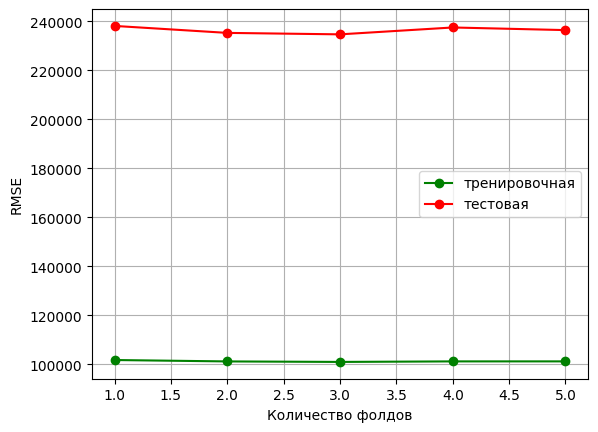

In [36]:
''' Как можно увидеть из графика модель показывает
устойчивый результат на тестовой выборке в районе 240 тыс.'''
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, rmse_train, 'o-', color='green', label='тренировочная')
plt.plot(folds, rmse_test, 'o-', color='red', label='тестовая')
plt.legend()
plt.grid()
plt.xlabel('Количество фолдов')
plt.ylabel('RMSE')
plt.show()

## Часть 5. Финальная подготовка модели. ##

In [37]:
import joblib
import json

In [39]:
path_model = "models/model.sav"
path_unique_values = "data/unique_values.json"

In [40]:
#Сохраним модел в отдельный файл
joblib.dump(clf, path_model)

#Так же сохраним уникальные значения из датесета в .JSON файл
dict_unique = {key: X[key].unique().tolist() for key in X.columns}
with open(path_unique_values, 'w') as file:
    json.dump(dict_unique, file)